# AMLB Visualizations
This notebook contains code to generate several figures from the Naive AutoML appendix in our paper.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import seaborn

from data_processing import get_print_friendly_name, impute_results, add_rescale
from visualization import FRAMEWORK_TO_COLOR

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures"
(FIGURE_DIRECTORY / "naml").mkdir(parents=True, exist_ok=True)

In [3]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results["framework"] = results["framework"].apply(get_print_friendly_name)

## Imputation of Missing Values
Sometimes frameworks do not finish. This can have various reasons such as violating time or memory constraints, or simple bugs in the software (cf. error visualization). As a rule, we impute these missing values with results of the `constantpredictor`. Our reasoning is detailed in the paper, but the short version is this: errors are often correlated with "dataset difficulty" and thus can not be simply ignored. Since we expect AutoML frameworks to have a reasonable fallback (such as random forest), and it takes effort and time to ensure this, we can not impute with such a baseline. The `constantpredictor` imputation is harsh, be we found it most fair.

In [4]:
results = impute_results(
    results,
    where=results["result"].isna(),
    with_="constantpredictor",
)

In our paper, we make one exception to this: there is one specific bug that affected 72 (of 1040) runs of AutoGluon(HQIL) specifically. This bug has been confirmed to be resolved in AutoGluon 0.8.3 (we benchmarked 0.8.0). Based on experiments, we can say with great confidence that the AutoGluon(HQIL) performance in 0.8.3 closely matches the AutoGluon(HQ) performance of 0.8.0. To better represent the AutoGluon(HQIL)'s performance, we chose to impute these specific missing values with AutoGluon(HQ) results. Missing results for AutoGluon(HQIL) that are not caused by this bug will be imputed with `constantpredictor` as usual.

In [5]:
# The AutoGluon(HQIL) can be uniquely recognized by the "'NoneType' object has no attribute 'name'" error message.
autogluon_bug = results["info"].apply(lambda v: isinstance(v, str) and "'NoneType' object has no attribute 'name'" in v)
results = impute_results(
    results,
    where=autogluon_bug,
    with_="AutoGluon(HQ)",
)

## Scaling Results
As described in the paper, we scale our results between RandomForest (0) and the best observed performance (1).
This makes results comparable across different metrics and datasets:

In [6]:
mean_results = results[["framework", "task", "constraint", "metric", "result", "imputed", "infer_batch_size_file_10000"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).agg(
    {"result": "mean", "infer_batch_size_file_10000": "mean", "imputed": "sum"}
)
lookup = mean_results.set_index(["framework", "task", "constraint"])
for index, row in mean_results.iterrows():
    lower = lookup.loc[("RandomForest", row["task"], row["constraint"]), "result"]
    upper = lookup.loc[(slice(None), row["task"], row["constraint"]), "result"].max()
    if lower == upper:
        mean_results.loc[index, "scaled"] = float("nan")
    else:
        mean_results.loc[index, "scaled"] = (row["result"] - lower) / (upper - lower)
        
mean_results.to_csv(DATA_DIRECTORY / f"processed-mean.csv", index=False)   

# Inference vs Performance

mean rescaled result vs median inference speed row/s at 10k and at 1

In [7]:
def calculate_pareto(xs, ys) -> list[tuple[float, float]]:
    pairs = set(zip(xs, ys))
    return [
        (x, y)
        for x, y in pairs
        # check below is only correct because `pairs` is a set so never x==x2 *and* y==y2
        if not any((x2>=x and y2 >=y) and (x!=x2 or y!=y2) for x2, y2 in pairs)
    ]

def plot_pareto(data, x, y, ax, color="#cccccc"):
    pareto = sorted(calculate_pareto(data[x], data[y]))
    for opt, next_opt in zip(pareto, pareto[1:]):
        ax.plot([opt[0], opt[0], next_opt[0]], [opt[1],next_opt[1], next_opt[1]], color=color, zorder=0)   


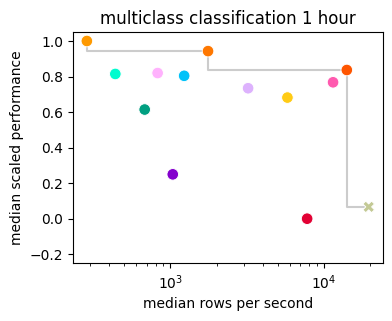

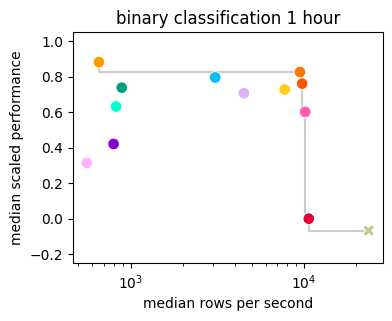

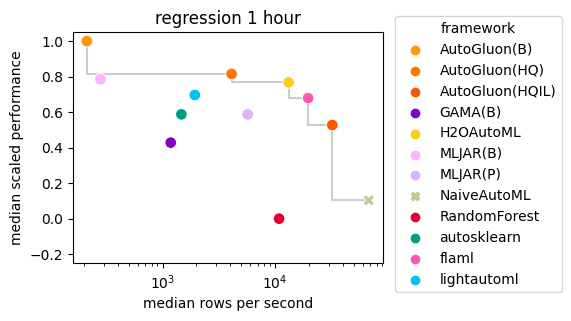

In [8]:
constraint = "1h8c_gp3"
time_budget = get_print_friendly_name(constraint)

for i, metric in enumerate(results["metric"].unique()):    
    ttype = {"neg_rmse": "regression", "auc": "binary classification", "neg_logloss": "multiclass classification"}[metric]
    exclude = ["constantpredictor", "TunedRandomForest", "TPOT"]
    if ttype == "regression":
        exclude += ["autosklearn2"]

    data = mean_results[~mean_results["framework"].isin(exclude)]
    data = data[(data["constraint"] == constraint)  & (data["metric"] == metric)]
    data = data.groupby(["framework", "constraint", "metric"])[["infer_batch_size_file_10000", "scaled"]].median()
    data["row_per_s"] = 10_000. / data["infer_batch_size_file_10000"]
    color_map = {k: v for k, v in FRAMEWORK_TO_COLOR.items() if k not in exclude}
    marker_map = {f: 'X' if f == "NaiveAutoML" else 'o' for f, v in color_map.items()}

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax = seaborn.scatterplot(
        data, 
        x="row_per_s", 
        y="scaled", 
        hue="framework",
        palette=color_map,
        s=70,  # marker size
        style="framework",
        markers=marker_map,
        ax=ax,
    )
    plot_pareto(data, x="row_per_s", y="scaled", ax=ax)
    ax.set_title(f"{ttype} {time_budget}")
    ax.set_xscale('log')
    ax.set_xlabel('median rows per second')
    ax.set_ylabel('median scaled performance')
    ax.set_ylim([-0.25, 1.05])
    seaborn.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1.1))
    if i != 2:
        plt.legend([],[], frameon=False)

    with PdfPages(FIGURE_DIRECTORY / "naml" / f"{ttype.replace(' ','-')}_{constraint}.pdf") as f:
        f.savefig(fig, bbox_inches="tight")

